TensorFlow version: 2.19.0
NEURAL STYLE TRANSFER

📸 UPLOAD GAMBAR KONTEN (Gambar Utama):


Saving Gambar WhatsApp 2025-12-03 pukul 00.29.08_63850ff0.jpg to Gambar WhatsApp 2025-12-03 pukul 00.29.08_63850ff0 (5).jpg
✓ File: Gambar WhatsApp 2025-12-03 pukul 00.29.08_63850ff0 (5).jpg

🎨 UPLOAD GAMBAR STYLE (Gambar Gaya):


Saving Gambar WhatsApp 2025-12-03 pukul 00.29.09_ae35009f.jpg to Gambar WhatsApp 2025-12-03 pukul 00.29.09_ae35009f (5).jpg
✓ File: Gambar WhatsApp 2025-12-03 pukul 00.29.09_ae35009f (5).jpg

Loading images...
Preprocessing...
Setup model...
Extracting features...

Running style transfer (50 iterations)...
Iteration 0: Loss = 6.24e+09
Iteration 10: Loss = 3.61e+09
Iteration 20: Loss = 2.13e+09
Iteration 30: Loss = 1.33e+09
Iteration 40: Loss = 9.71e+08
Iteration 49: Loss = 7.73e+08
Done!


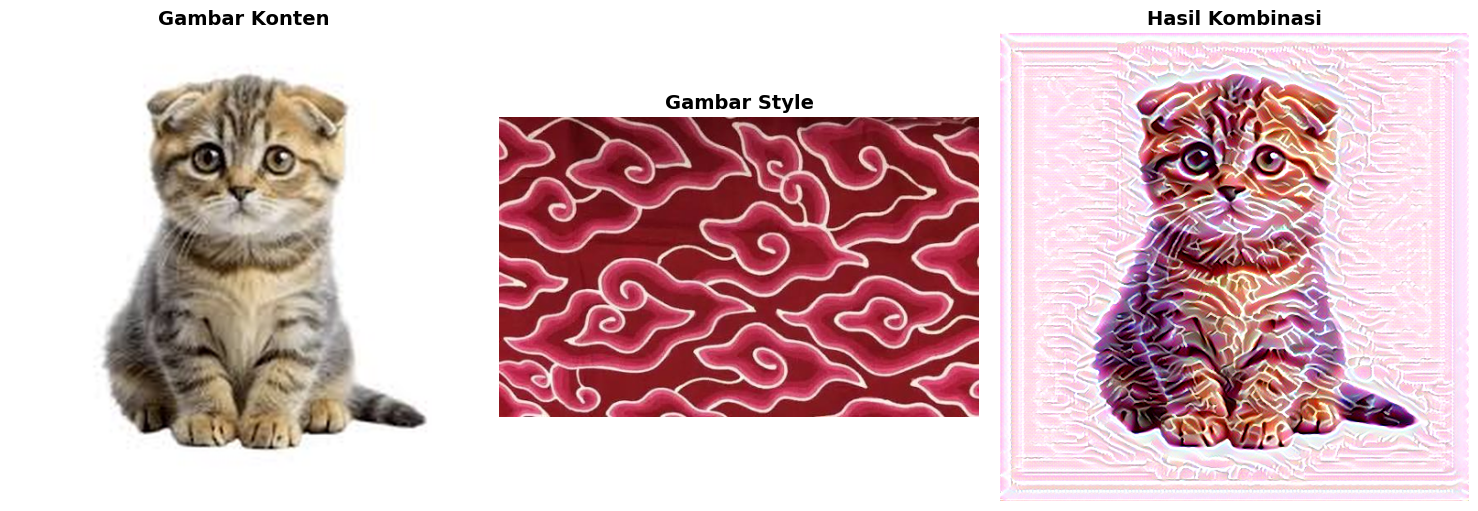

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from PIL import Image
from google.colab import files

print("TensorFlow version:", tf.__version__)

# 1. Fungsi Load dan Proses Gambar (FIXED)
def load_image(path, max_dim=512):
    img = Image.open(path).convert('RGB')
    scale = max_dim / max(img.size)
    img = img.resize(tuple([int(d * scale) for d in img.size]), Image.LANCZOS)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    return tf.convert_to_tensor(img, dtype=tf.float32)

def preprocess_image(img):
    # VGG19 preprocessing: BGR dan mean substraction
    img = tf.reverse(img, axis=[-1])  # RGB to BGR
    img = img - [103.939, 116.779, 123.68]  # Mean substraction
    return img

def deprocess_image(img):
    img = img.copy()
    img = img.reshape((img.shape[1], img.shape[2], 3))
    # Reverse preprocessing
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # BGR to RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# 2. Setup Model
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Layer untuk ekstraksi fitur
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']

    outputs = [vgg.get_layer(name).output for name in (content_layers + style_layers)]
    model = keras.Model([vgg.input], outputs)
    return model

# 3. Loss Functions
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def compute_loss(model, content_features, style_grams, generated_img):
    generated_features = model(generated_img)

    # Content loss
    content_loss = tf.reduce_mean(tf.square(content_features - generated_features[0]))

    # Style loss
    style_loss = 0
    for i in range(len(style_grams)):
        generated_gram = gram_matrix(generated_features[i + 1][0])
        style_loss += tf.reduce_mean(tf.square(style_grams[i] - generated_gram))

    # Total loss dengan bobot yang seimbang
    total_loss = 10.0 * content_loss + 1.0 * style_loss
    return total_loss

# 4. Training Step
@tf.function
def train_step(model, content_features, style_grams, generated_img, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, content_features, style_grams, generated_img)

    grads = tape.gradient(loss, generated_img)
    optimizer.apply_gradients([(grads, generated_img)])

    # Clip values agar tetap dalam range valid
    generated_img.assign(
        tf.clip_by_value(generated_img,
                        -103.939 - 20,  # min BGR value
                        255 - 123.68 + 20)  # max BGR value
    )
    return loss

# 5. Main Function
def run_style_transfer(content_path, style_path, iterations=50):
    print("Loading images...")
    content_img = load_image(content_path)
    style_img = load_image(style_path)

    print("Preprocessing...")
    content_preprocessed = preprocess_image(content_img)
    style_preprocessed = preprocess_image(style_img)

    print("Setup model...")
    model = get_model()

    # Extract features
    print("Extracting features...")
    content_features = model(content_preprocessed)[0]
    style_features = model(style_preprocessed)[1:]
    style_grams = [gram_matrix(feature[0]) for feature in style_features]

    # Initialize generated image with content
    generated_img = tf.Variable(content_preprocessed)

    # Optimizer dengan learning rate kecil
    optimizer = tf.optimizers.Adam(learning_rate=2.0)

    print(f"\nRunning style transfer ({iterations} iterations)...")
    for i in range(iterations):
        loss = train_step(model, content_features, style_grams, generated_img, optimizer)
        if i % 10 == 0 or i == iterations - 1:
            print(f"Iteration {i}: Loss = {loss.numpy():.2e}")

    print("Done!")

    # Show results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(content_img.numpy()[0].astype('uint8'))
    plt.title('Gambar Konten', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(style_img.numpy()[0].astype('uint8'))
    plt.title('Gambar Style', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    result = deprocess_image(generated_img.numpy())
    plt.imshow(result)
    plt.title('Hasil Kombinasi', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return result

# 6. UPLOAD DAN JALANKAN

print("=" * 50)
print("NEURAL STYLE TRANSFER")
print("=" * 50)

print("\n📸 UPLOAD GAMBAR KONTEN (Gambar Utama):")
uploaded_content = files.upload()
content_path = list(uploaded_content.keys())[0]
print(f"✓ File: {content_path}")

print("\n🎨 UPLOAD GAMBAR STYLE (Gambar Gaya):")
uploaded_style = files.upload()
style_path = list(uploaded_style.keys())[0]
print(f"✓ File: {style_path}")

print("\n" + "=" * 50)

# Jalankan style transfer
result = run_style_transfer(content_path, style_path, iterations=50)